Import necessary libraries and data.

In [81]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD

from sklearn.cluster import SpectralBiclustering, SpectralCoclustering

In [82]:
df = pd.read_csv('authors.csv').rename(columns = {'Unnamed: 0': 'Author'})
df = df.drop('BookID',axis=1)
X = df.copy().drop(['Author'], axis=1)
authors = df['Author'].values  # n_samples-length array

### Biclustering

Let us fit and visualize both the chapters and words using Spectral Biclustering!

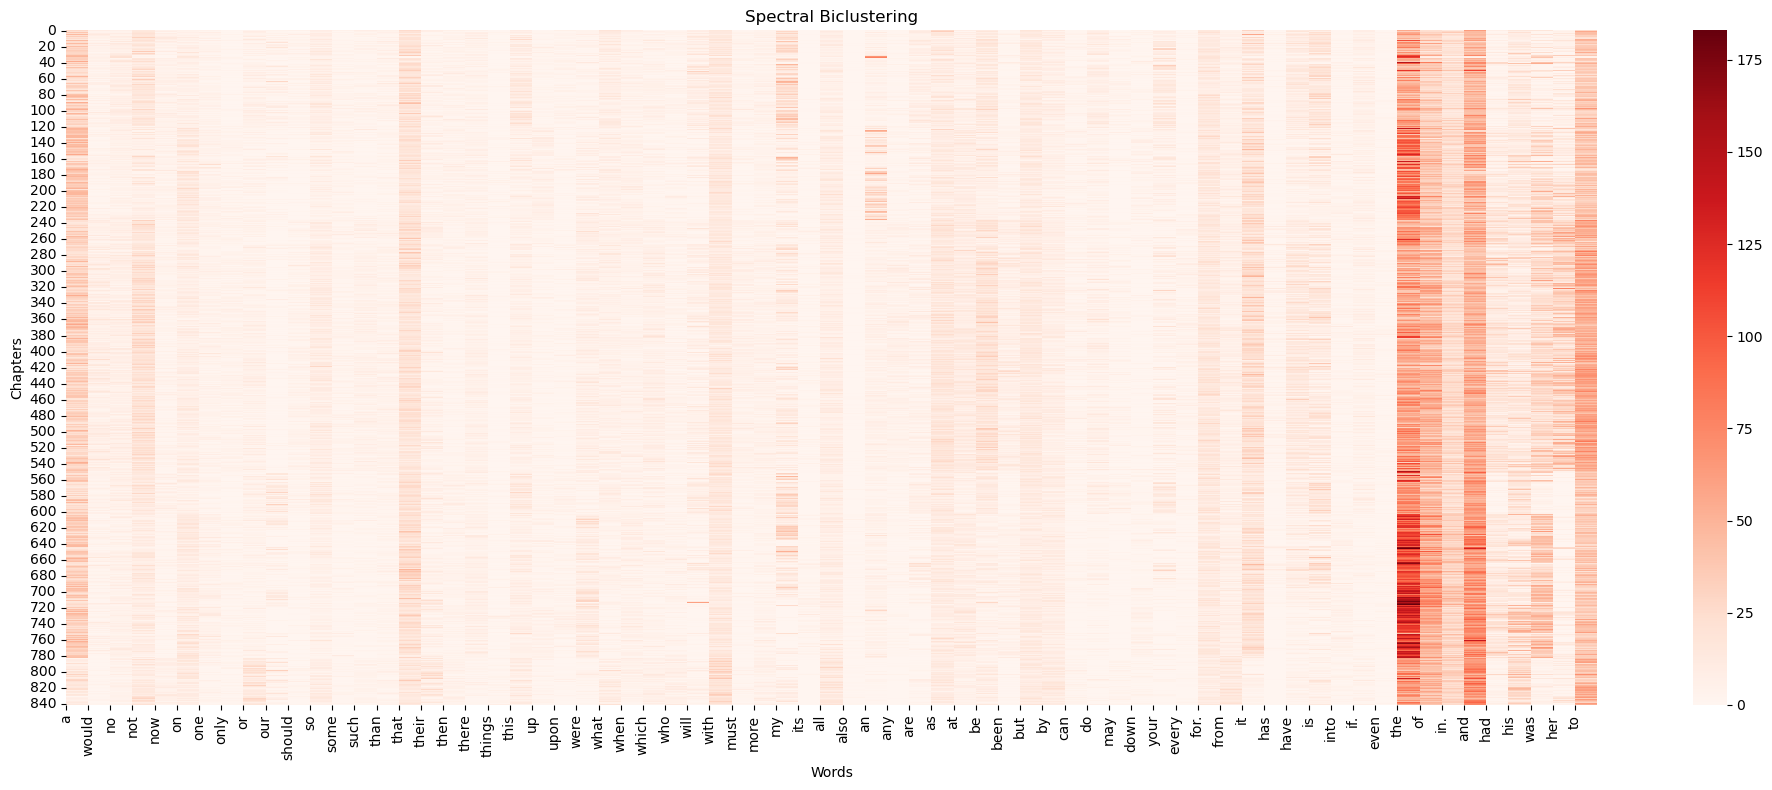

In [83]:
### Fit biclustering model
model = SpectralBiclustering(n_clusters=4, method='log', random_state=0)
model.fit(X)

### Reorder the data
row_order = np.argsort(model.row_labels_)
col_order = np.argsort(model.column_labels_)
fit_data = X.values[row_order][:, col_order]

### Get reordered word labels for x-axis
word_labels = X.columns[col_order]

### Visualization
plt.figure(figsize=(20, 8))  # wider figurea
sns.heatmap(fit_data, cmap="Reds", cbar=True)
plt.xticks(ticks=np.arange(len(word_labels)), labels=word_labels, rotation=90)
plt.title("Spectral Biclustering")
plt.xlabel("Words")
plt.ylabel("Chapters")
plt.tight_layout()

plt.savefig('Biclustering-Heatmap')


Since words like "the", "and", "to", ... are used frequently across chapters on a global level there is not much insights to be deduced here.  We want to look for at words with specific chapters having bands.  This will help us to differentiate a word that is frequently used across a cluster of chapters indicating stylistic writing by the author!  This will help with classifying these chapters to their respective authors!!  There is a small problem that the common words are very dark so it is harder to see a contrast in scale so we will convert the scale to log scale to see a larger contrast among the less frequently used words.

#### Log-Scale (Improve Visualization)

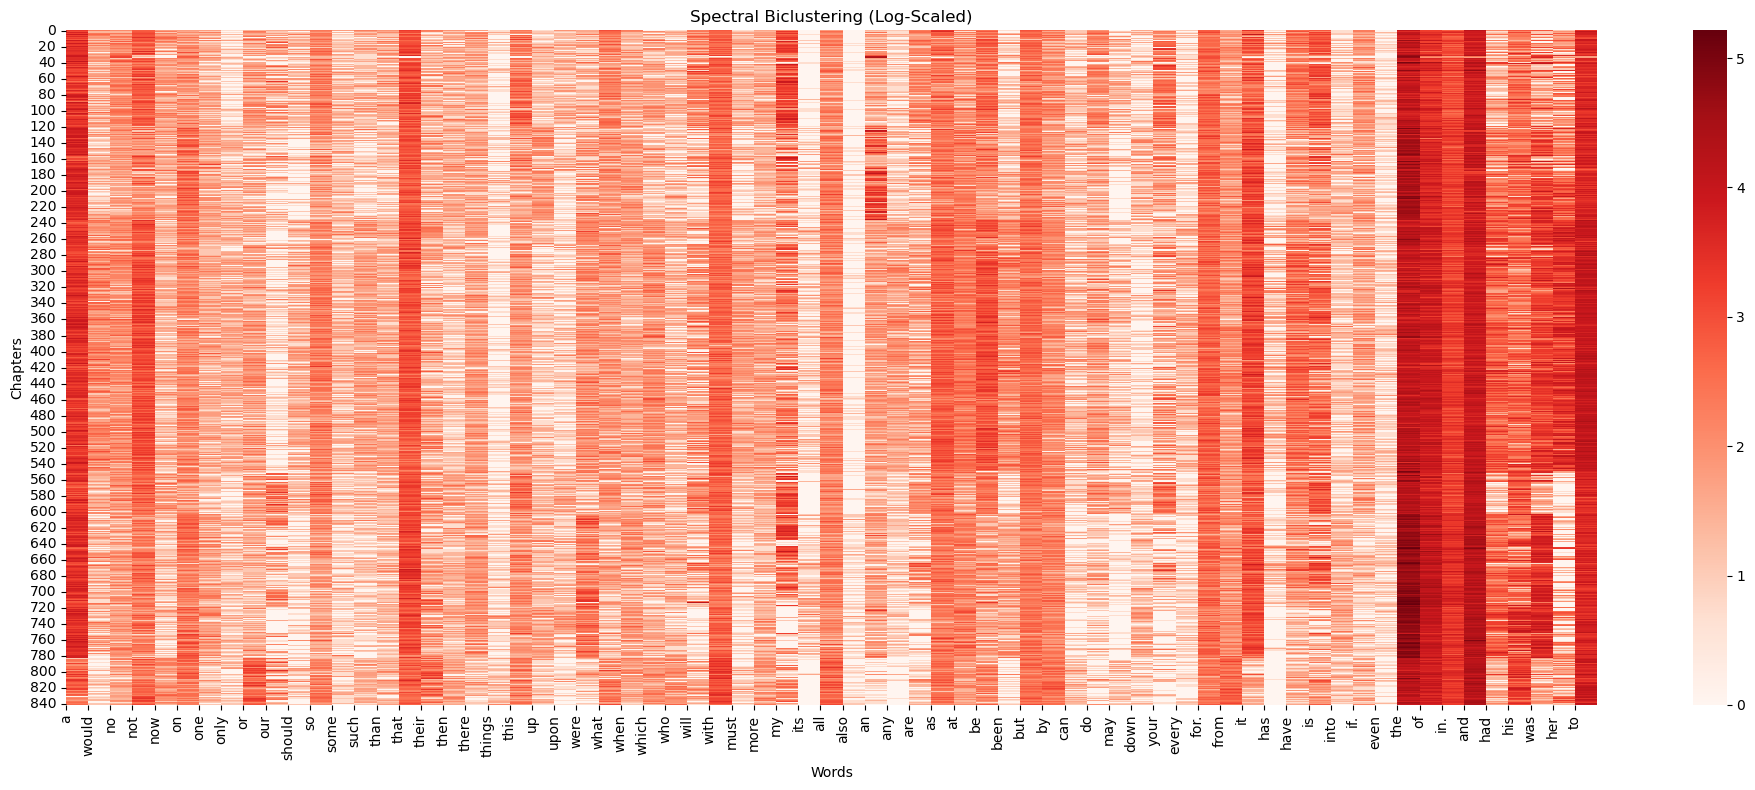

In [84]:
### Reorder the data
row_order = np.argsort(model.row_labels_)
col_order = np.argsort(model.column_labels_)
fit_data = X.values[row_order][:, col_order]

### Get reordered word labels for x-axis
word_labels = X.columns[col_order]

### Apply log scale to compress high-frequency words like "the"
log_data = np.log1p(fit_data)  # log(1 + x) to avoid log(0)

### Plot the heatmap
plt.figure(figsize=(20, 8))
sns.heatmap(log_data, cmap="Reds", cbar=True)

plt.xticks(ticks=np.arange(len(word_labels)), labels=word_labels, rotation=90)
plt.title("Spectral Biclustering (Log-Scaled)")
plt.xlabel("Words")
plt.ylabel("Chapters")
plt.tight_layout()

plt.savefig('Biclustering-Heatmap-logscale')

Plot side by side for visualization/comparison purposes.

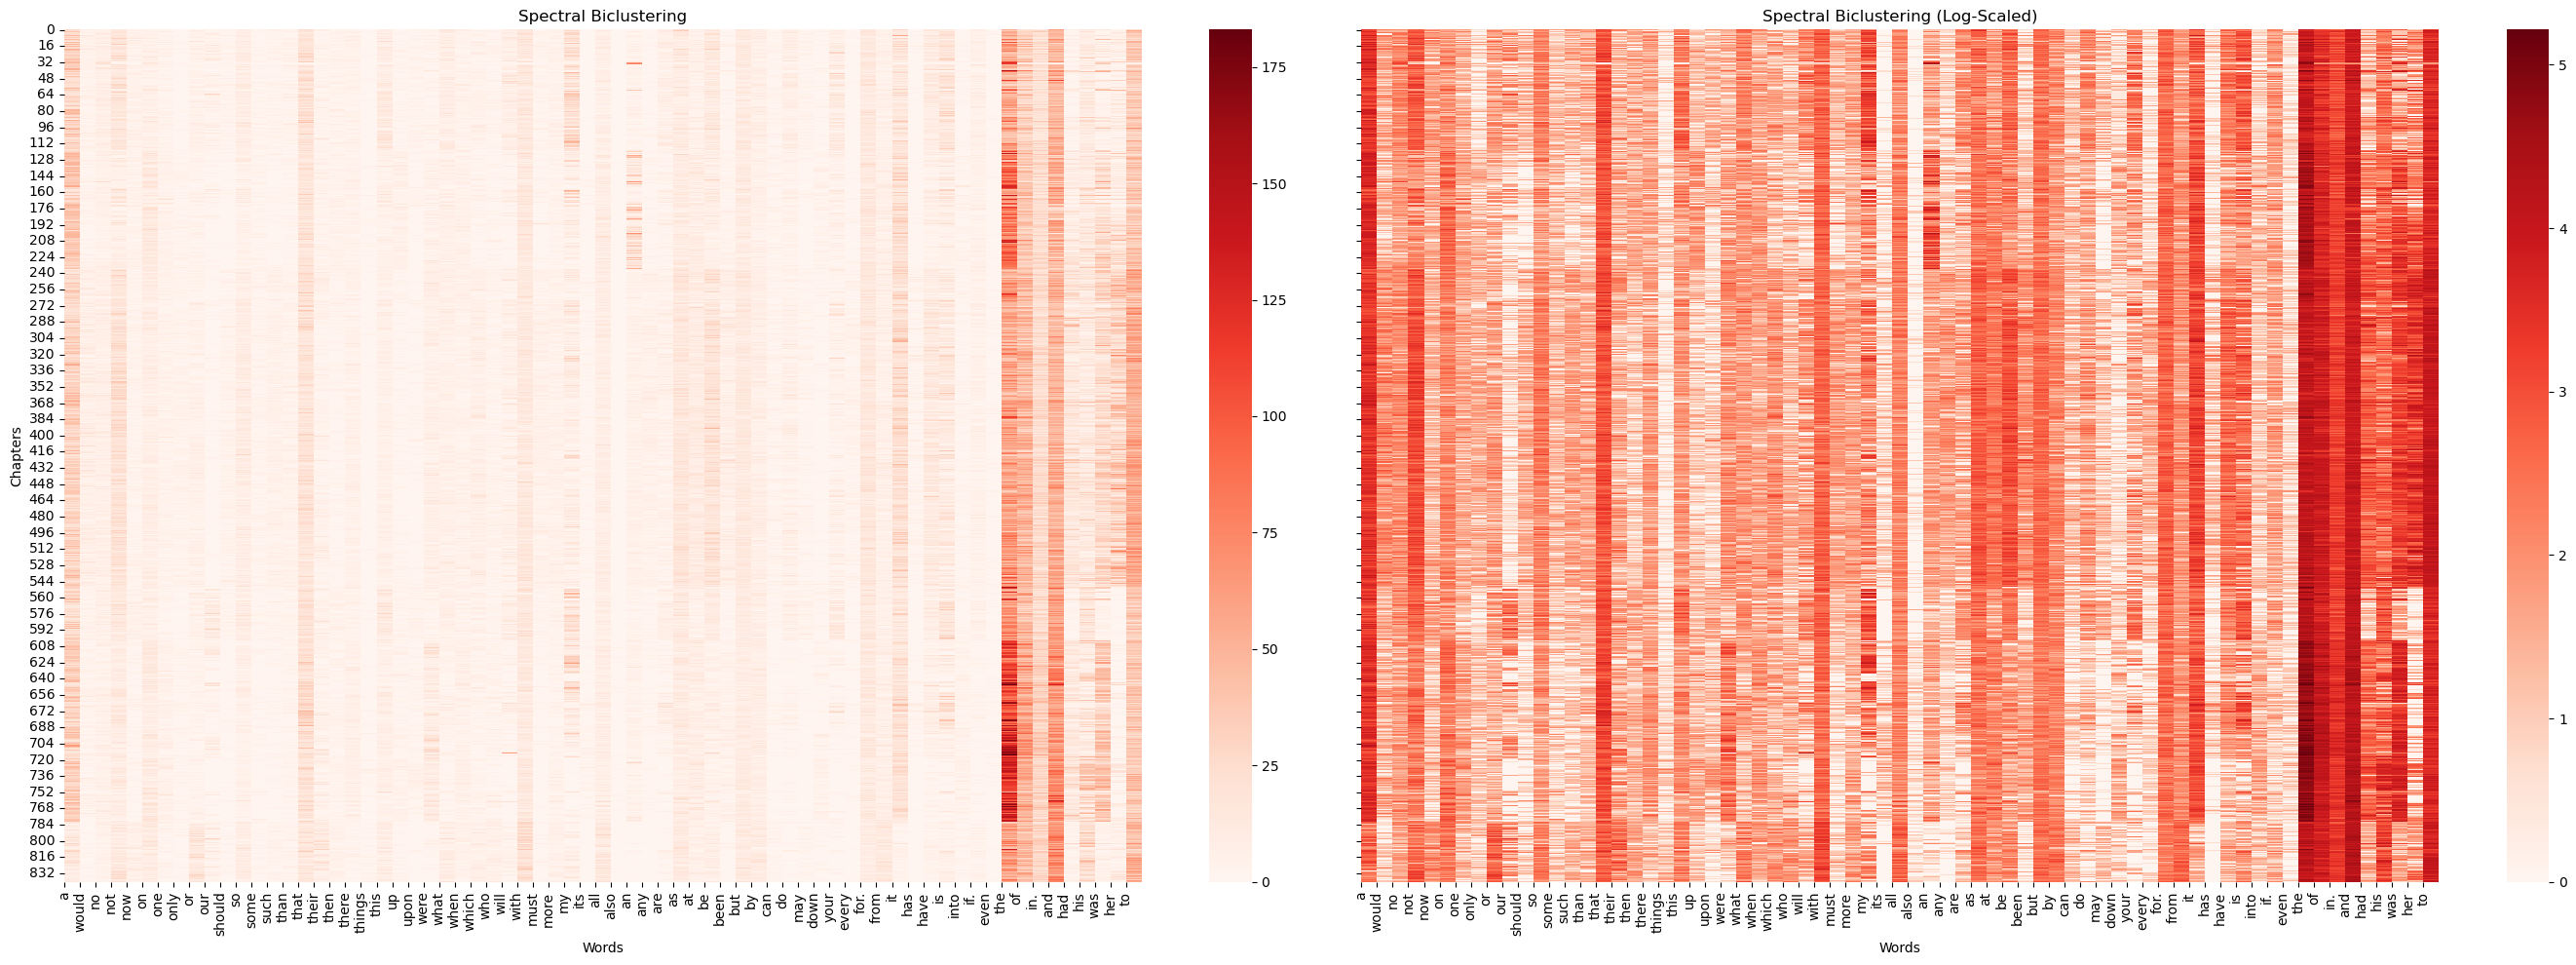

In [85]:
# Plot side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(28, 10), sharey=True)

# Original
sns.heatmap(fit_data, cmap="Reds", ax=axes[0], cbar=True)
axes[0].set_xticks(np.arange(len(word_labels)))
axes[0].set_xticklabels(word_labels, rotation=90)
axes[0].set_title("Spectral Biclustering")
axes[0].set_xlabel("Words")
axes[0].set_ylabel("Chapters")

# Log-scaled
sns.heatmap(log_data, cmap="Reds", ax=axes[1], cbar=True)
axes[1].set_xticks(np.arange(len(word_labels)))
axes[1].set_xticklabels(word_labels, rotation=90)
axes[1].set_title("Spectral Biclustering (Log-Scaled)")
axes[1].set_xlabel("Words")
axes[1].set_ylabel("")

plt.tight_layout()

plt.savefig('Biclustering-Heatmap-two')
